In [ ]:
import pandas as pd
import numpy as np
import torch 
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm

In [ ]:
data_directory = "../Data/unh_hackathon_prompt_2_data.json"
sys.path.append("../UNH-Hackathon-2026-Group-3/")

## preparing the data


In [ ]:
def load_predictive_warfighting_data(file_path: str = "unh_hackathon_prompt_2_data.json") -> pd.DataFrame:
    """Load data from a CSV file into a pandas DataFrame."""
    return pd.read_json(file_path)

dirty_df = load_predictive_warfighting_data(data_directory)

# print data types of each column
# print(dirty_df.dtypes)

In [ ]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """Clean the DataFrame by converting data types."""

    # Convert the string "NULL" to pd.NA
    df = df.replace("NULL", pd.NA)
    df = df.replace("N/A", pd.NA)

    for numeric_string_column in [
        "Enemy.Capability.Index",
        "EW_Capability",
        "Intel Confidence",

    ]:
        df[numeric_string_column] = pd.to_numeric(df[numeric_string_column])

    for boolean_string_column in [
        "response_success"
    ]:
        df[boolean_string_column] = df[boolean_string_column].map({"Yes": 1, "No": 0, "1": 1, "0": 0})

    return df

df = clean_data(dirty_df)

# get unique values for each string column, and min/max for each numeric column
for column in df.columns:
    if df.dtypes[column] == "str":
        print(f"Values: {df[column].drop_duplicates()}")
    else: 
        print(f"Name: {column}, dtype: {df.dtypes[column]}, min: {df[column].min()}, max: {df[column].max()}")

print(f"number of rows: {len(df)}")     
df.head()

Values: 0       Missile
2           Air
3         Cyber
4        Hybrid
7         Naval
14          AIR
35        CYBER
39       Hybrid
43          Msl
79        naval
119       Cyber
239         AIR
279         Air
299       naval
319     Missile
Name: Threat Type, dtype: str
Name: enemy_unit_count, dtype: int64, min: 1, max: 50
Name: Enemy.Capability.Index, dtype: int64, min: 1, max: 10
Name: ThreatEscalationHours, dtype: int64, min: 1, max: 72
Name: friendlyUnitCount, dtype: int64, min: 5, max: 60
Name: LCS_COUNT, dtype: int64, min: 0, max: 8
Name: Aircraft Count, dtype: int64, min: 0, max: 24
Name: cyber_defense_teams, dtype: int64, min: 0, max: 12
Name: Patriot.Batteries, dtype: int64, min: 0, max: 6
Name: ISR_AssetCount, dtype: int64, min: 0, max: 15
Name: satellite coverage score, dtype: float64, min: 0.2, max: 1.0
Name: JointForceIntegration, dtype: int64, min: 1, max: 10
Name: EW_Capability, dtype: float64, min: 0.0, max: 10.0
Name: Supply Chain Resilience, dtype: float64, min

,Threat Type,enemy_unit_count,Enemy.Capability.Index,ThreatEscalationHours,friendlyUnitCount,LCS_COUNT,Aircraft Count,cyber_defense_teams,Patriot.Batteries,ISR_AssetCount,...,CMD_COORD_SCORE,roe_complexity_score,Operational Budget (MUSD),BudgetUtilization_pct,Weather_Severity,Theater Distance KM,Season,response_success,Financial_Loss_MUSD,actual_days_to_stabilization
0,Missile,25,8,34,21,0,0,0,4,12,...,7,3,98,84,3,5164.8,Winter,1,388,10.1
1,Missile,3,2,8,45,0,0,0,4,4,...,9,5,189,97,1,7149.7,Fall,1,244,2.0
2,Air,7,3,48,45,0,5,0,0,14,...,9,1,92,88,0,6706.5,Winter,1,280,2.0
3,Cyber,31,7,70,57,0,0,7,0,5,...,10,3,314,86,9,1851.9,Fall,1,330,5.3
4,Hybrid,14,5,27,57,0,0,0,0,10,...,6,4,290,84,4,983.7,Spring,1,240,11.0


In [ ]:
# get count of rows for each threat type 
threat_type_counts = df["Threat Type"].value_counts()
threat_type_counts

Threat Type
Naval       741
Air         684
Hybrid      557
Cyber       425
Missile     408
AIR          42
CYBER        32
Msl          21
 naval       19
 Hybrid      15
naval        15
 Cyber       13
 Missile     13
 Air         10
 AIR          5
Name: count, dtype: int64

In [ ]:
# combine "Naval", "  naval", and "naval" into same category 
df["Threat Type"] = df["Threat Type"].str.strip()  # Remove leading/trailing whitespace
df["Threat Type"] = df["Threat Type"].str.lower()  # Convert to lowercase for consistency

# combine missile and msl into same threat type 
df["Threat Type"] = df["Threat Type"].replace({"msl": "missile"})

threat_type_counts = df["Threat Type"].value_counts()
threat_type_counts


Threat Type
naval      775
air        741
hybrid     572
cyber      470
missile    442
Name: count, dtype: int64

In [ ]:
# remove rows with nan values in any column 
df = df.dropna()
len(df)

2945

In [ ]:
# get a list of the column names and data types 
for column in df.columns:
    print(f"{column}, dtype: {df.dtypes[column]}")

Threat Type, dtype: str
enemy_unit_count, dtype: int64
Enemy.Capability.Index, dtype: int64
ThreatEscalationHours, dtype: int64
friendlyUnitCount, dtype: int64
LCS_COUNT, dtype: int64
Aircraft Count, dtype: int64
cyber_defense_teams, dtype: int64
Patriot.Batteries, dtype: int64
ISR_AssetCount, dtype: int64
satellite coverage score, dtype: float64
JointForceIntegration, dtype: int64
EW_Capability, dtype: float64
Supply Chain Resilience, dtype: float64
PriorEngagements, dtype: int64
force_readiness_score, dtype: int64
Intel Confidence, dtype: float64
ResponseTime_hrs, dtype: int64
logistics_delay_hours, dtype: int64
CMD_COORD_SCORE, dtype: int64
roe_complexity_score, dtype: int64
Operational Budget (MUSD), dtype: int64
BudgetUtilization_pct, dtype: int64
Weather_Severity, dtype: int64
Theater Distance KM, dtype: float64
Season, dtype: str
response_success, dtype: int64
Financial_Loss_MUSD, dtype: int64
actual_days_to_stabilization, dtype: float64


In [ ]:
# get array of the values for each continuous input variable: 
'''['satellite coverage score',
 'EW_Capability',
 'Supply Chain Resilience',
 'Intel Confidence',
 'Theater Distance KM',
 'actual_days_to_stabilization']'''

satellite_coverage_scores = df['satellite coverage score'].values
ew_capabilities = df['EW_Capability'].values
supply_chain_resiliencies = df['Supply Chain Resilience'].values
intel_confidences = df['Intel Confidence'].values
theater_distances_km = df['Theater Distance KM'].values
actual_days_to_stabilizations = df['actual_days_to_stabilization'].values 

def normalize(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

inputs = np.array([
    normalize(satellite_coverage_scores), 
    normalize(ew_capabilities), 
    normalize(supply_chain_resiliencies), 
    normalize(intel_confidences), 
    normalize(theater_distances_km)])

# get array of values for output variables:
'''
response_success, dtype: int64
Financial_Loss_MUSD, dtype: int64
actual_days_to_stabilization, dtype: float64
'''
response_successes = df['response_success'].values
financial_loss_musds = df['Financial_Loss_MUSD'].values
actual_days_to_stabilizations = df['actual_days_to_stabilization'].values

output = normalize(financial_loss_musds)

len(actual_days_to_stabilizations), len(financial_loss_musds)

(2945, 2945)

In [ ]:
# plot input vs output for each input variable 
for i in range(len(inputs)):
    plt.figure()
    plt.scatter(inputs[i], output)
    plt.xlabel(f"Input Variable {i+1}")
    plt.ylabel("Financial Loss (normalized)")
    plt.title(f"Input Variable {i+1} vs Financial Loss")
    plt.show()

## preparing the model 

In [10]:
class NNmodel(nn.Module):
    def __init__ (self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(len(inputs), 12),
            nn.ReLU(),
            nn.Linear(12, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [11]:
class AbsDataset(Dataset):
    def __init__ (self, inputs, output):
        self.input_tensor = torch.tensor(inputs).t().float() 
        self.output_tensor = torch.tensor(output).float()
        
    def __len__(self):
        return len(self.output_tensor)
    
    def __getitem__(self, idx):
        return self.input_tensor[idx], self.output_tensor[idx] 
    

In [12]:
full_dataset = AbsDataset(inputs, output)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# shuffles and batches 
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# initiate model
model = NNmodel()
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) # learning rate


In [13]:
# training with per-epoch testing
training_loss_ls = []
test_loss_ls = []

epochs = 20

for epoch in range(epochs):
    epoch_loss_ls = []
    print("epoch #:", epoch)

    # training loop 
    for data, labels in tqdm(train_loader):
        optimizer.zero_grad() # resets gradients in optimizer to 0 
        outputs = model(data)

        # calculate loss function (MSE)
        loss = loss_func(outputs, labels)
        epoch_loss_ls.append(loss.item())
        loss.backward() # back prop 

        # optimizer 
        optimizer.step() # updates all parameters via gradient descent 
        
    avg_loss = np.average(np.array(epoch_loss_ls))
    print("average training loss:", avg_loss)
    training_loss_ls.append(avg_loss)
    
    # testing loop per epoch
    test_epoch_ls = []
    with torch.no_grad():
        for data, labels in test_loader:
            outputs = model(data)
            loss = loss_func(outputs, labels)
            test_epoch_ls.append(loss.item())
    
    avg_test_loss = np.average(np.array(test_epoch_ls))
    print("average test loss:", avg_test_loss)
    test_loss_ls.append(avg_test_loss)

epoch #: 0


  0%|          | 0/74 [00:00<?, ?it/s]/Users/katherinesong/UNH-Hackathon-2026-Group-3/.venv/lib/python3.14/site-packages/torch/nn/modules/loss.py:626: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/katherinesong/UNH-Hackathon-2026-Group-3/.venv/lib/python3.14/site-packages/torch/nn/modules/loss.py:626: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 74/74 [00:00<00:00, 916.96it/s]
/Users/katherinesong/UNH-Hackathon-2026-Group-3/.venv/lib/python3.14/site-packages/torch/nn/modules/loss.py:626: UserWarning: Using a tar

average training loss: 0.13836172656030268
average test loss: 0.07435090584995403
epoch #: 1


100%|██████████| 74/74 [00:00<00:00, 2929.20it/s]

average training loss: 0.03864751358491343


average test loss: 0.027144588199878607
epoch #: 2


100%|██████████| 74/74 [00:00<00:00, 2904.81it/s]


average training loss: 0.022286771318397007
average test loss: 0.02503966144293064
epoch #: 3


100%|██████████| 74/74 [00:00<00:00, 3016.46it/s]


average training loss: 0.021818761336239608
average test loss: 0.024758437123376574
epoch #: 4


100%|██████████| 74/74 [00:00<00:00, 2687.47it/s]


average training loss: 0.021603160588121093
average test loss: 0.024362743211013876
epoch #: 5


100%|██████████| 74/74 [00:00<00:00, 2783.94it/s]


average training loss: 0.02136313425679062
average test loss: 0.0241388754546156
epoch #: 6


100%|██████████| 74/74 [00:00<00:00, 2751.85it/s]


average training loss: 0.021048152076734883
average test loss: 0.023809517619851762
epoch #: 7


100%|██████████| 74/74 [00:00<00:00, 2666.18it/s]


average training loss: 0.020979688326651987
average test loss: 0.02366213848785473
epoch #: 8


100%|██████████| 74/74 [00:00<00:00, 2701.93it/s]


average training loss: 0.020867229187609377
average test loss: 0.023505158032880513
epoch #: 9


100%|██████████| 74/74 [00:00<00:00, 2923.38it/s]


average training loss: 0.020753297262598534
average test loss: 0.023448192562079397
epoch #: 10


100%|██████████| 74/74 [00:00<00:00, 2927.93it/s]


average training loss: 0.020734272721047338
average test loss: 0.023423464828143097
epoch #: 11


100%|██████████| 74/74 [00:00<00:00, 2957.65it/s]

average training loss: 0.020652248196907946


average test loss: 0.02333267915429816
epoch #: 12


100%|██████████| 74/74 [00:00<00:00, 2935.22it/s]

average training loss: 0.02064547483884805


average test loss: 0.023285357898158474
epoch #: 13


100%|██████████| 74/74 [00:00<00:00, 1356.95it/s]


average training loss: 0.02070153086773447
average test loss: 0.023330694141245105
epoch #: 14


100%|██████████| 74/74 [00:00<00:00, 1859.12it/s]

average training loss: 0.02063095409775505


average test loss: 0.023438997296179
epoch #: 15


100%|██████████| 74/74 [00:00<00:00, 2470.62it/s]


average training loss: 0.020620826921249565
average test loss: 0.02329966915577603
epoch #: 16


100%|██████████| 74/74 [00:00<00:00, 2892.30it/s]

average training loss: 0.02057888516149408


average test loss: 0.023348502438157812
epoch #: 17


100%|██████████| 74/74 [00:00<00:00, 2892.54it/s]


average training loss: 0.02057669745959543
average test loss: 0.023290380000641084
epoch #: 18


100%|██████████| 74/74 [00:00<00:00, 2920.06it/s]


average training loss: 0.020567061278868367
average test loss: 0.02323472953598212
epoch #: 19


100%|██████████| 74/74 [00:00<00:00, 2797.74it/s]


average training loss: 0.020582328273637873
average test loss: 0.02325672270528403


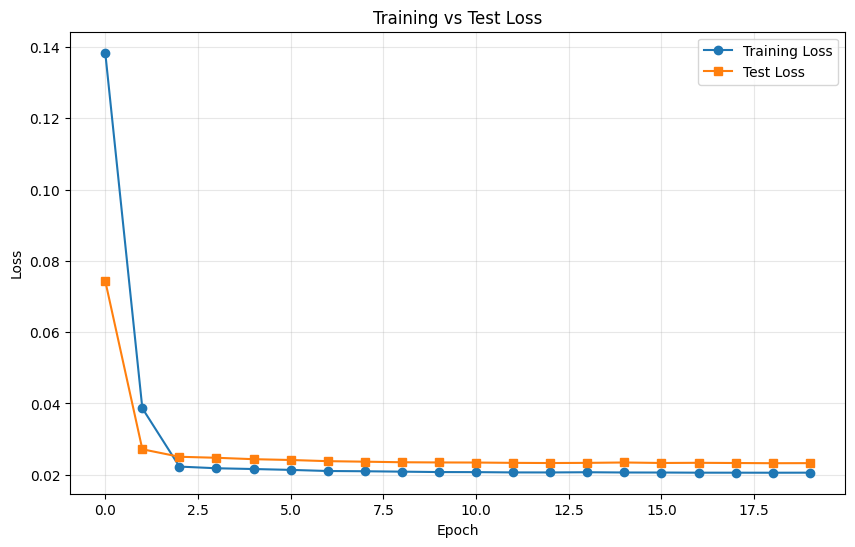

In [14]:
# Plot training and test loss together
x = range(epochs)
plt.figure(figsize=(10, 6))
plt.plot(x, training_loss_ls, label='Training Loss', marker='o')
plt.plot(x, test_loss_ls, label='Test Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Test Loss')
plt.grid(True, alpha=0.3)
plt.show()

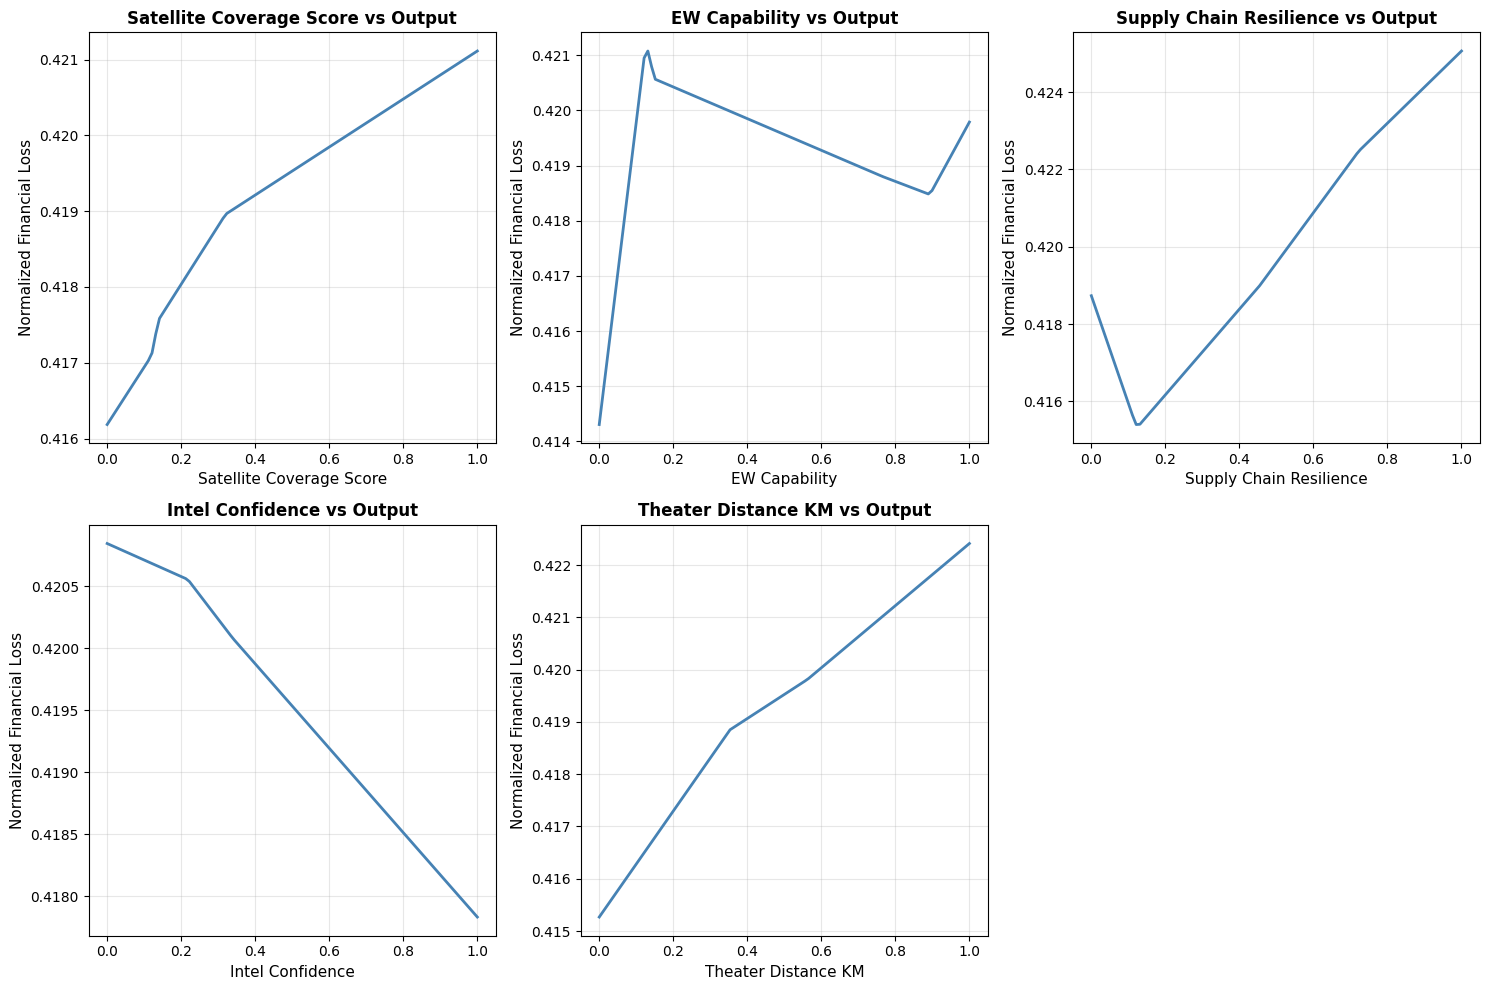

In [ ]:
# ai generated code: 
# Visualize surrogate model: 2D plots of each input vs output
# Create a 2x3 grid with one blank space for the 5 inputs

input_names = [
    'Satellite Coverage Score',
    'EW Capability',
    'Supply Chain Resilience',
    'Intel Confidence',
    'Theater Distance KM'
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# For each input variable, create predictions while varying that input
for i, ax in enumerate(axes):
    if i < 5:  # Only plot 5 subplots (leave last one blank)
        # Create a range of values for the input variable
        input_range = np.linspace(0, 1, 100)
        
        # Create prediction arrays by holding other inputs at their mean
        predictions = []
        
        for val in input_range:
            # Start with mean normalized values for all inputs
            input_vector = np.mean(inputs, axis=1)
            
            # Vary the current input
            input_vector[i] = val
            
            # Convert to tensor and predict
            input_tensor = torch.tensor(input_vector).float().unsqueeze(0)
            with torch.no_grad():
                pred = model(input_tensor).item()
            predictions.append(pred)
        
        # Plot
        ax.plot(input_range, predictions, linewidth=2, color='steelblue')
        ax.set_xlabel(input_names[i], fontsize=11)
        ax.set_ylabel('Normalized Financial Loss', fontsize=11)
        ax.set_title(f'{input_names[i]} vs Output', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
    else:
        # Leave the last subplot blank
        ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from IPython.display import display
import ipywidgets as widgets

model.eval()

sliders = {
    "satellite": widgets.FloatSlider(
        value=0.5, min=0, max=1, step=0.01,
        description="Satellite", continuous_update=False
    ),
    "ew": widgets.FloatSlider(
        value=0.5, min=0, max=1, step=0.01,
        description="EW Cap", continuous_update=False
    ),
    "supply_chain": widgets.FloatSlider(
        value=0.5, min=0, max=1, step=0.01,
        description="Supply Chain", continuous_update=False
    ),
    "intel": widgets.FloatSlider(
        value=0.5, min=0, max=1, step=0.01,
        description="Intel Conf", continuous_update=False
    ),
    "distance": widgets.FloatSlider(
        value=0.5, min=0, max=1, step=0.01,
        description="Theater Dist", continuous_update=False
    ),
}

output = widgets.Label()

def update_prediction(change=None):
    x = torch.tensor(
        [[sliders[k].value for k in sliders]],
        dtype=torch.float32
    )
    with torch.no_grad():
        pred = model(x).item()
    output.value = f"Normalized Financial Loss: {pred:.6f}"

for s in sliders.values():
    s.observe(update_prediction, names="value")

ui = widgets.VBox([
    sliders["satellite"],
    sliders["ew"],
    sliders["supply_chain"],
    sliders["intel"],
    sliders["distance"],
    output
])

display(ui)
update_prediction()


FloatSlider(value=0.5, continuous_update=False, description='Satellite', max=1.0, step=0.01)

FloatSlider(value=0.5, continuous_update=False, description='EW Cap', max=1.0, step=0.01)

FloatSlider(value=0.5, continuous_update=False, description='Supply Chain', max=1.0, step=0.01)

FloatSlider(value=0.5, continuous_update=False, description='Intel Conf', max=1.0, step=0.01)

FloatSlider(value=0.5, continuous_update=False, description='Theater Dist', max=1.0, step=0.01)

Label(value='')

In [1]:
import ipywidgets as widgets
from IPython.display import display

display(widgets.IntSlider())

IntSlider(value=0)